In [5]:
# import librosa
import numpy as np

import scattering

from IPython.display import Audio

import matplotlib.pylab as plt
%matplotlib inline

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
import esc_utils as U

def create_dataset(npz_path, split = 4, fs = 16000,
                   augment_factor = 9,  strong = True):
# tfrecord_pathes = pathes for train, val tfrecords    
    with np.load(npz_path) as dataset:

        train_sounds, train_labels = [], []
        val_sounds, val_labels = [], []

        for i, fold in enumerate(dataset.files):
            sounds = dataset[fold].item()['sounds']
            labels = dataset[fold].item()['labels']
            
            
            # we'll add to dataset only samples with length >= 40000
            idxs = list(filter(lambda i: len(sounds[i]) >= 40000,
                               range(len(sounds))))
            sounds = list(np.array(sounds)[idxs])
            labels = list(np.array(labels)[idxs])
            
            print('Preprocessing sounds...')
            sounds = [U.preprocess_sound(sound) for sound in sounds]
#             print(len(sounds), len(labels))            
                    
            if i  == split:
                val_sounds.extend(sounds)
                val_labels.extend(labels)
            else:
                
                print('Augmenting data...')
                if augment_factor:
                    augmented_sounds, augmented_labels = [], []
                
                    for sound, label in zip(sounds, labels):
                        augmented_sounds.extend([U.augment_sound(sound, strong = strong)
                                                 for _ in range(augment_factor)])
                        augmented_labels.extend([label]*augment_factor)

                    sounds.extend(augmented_sounds)
                    labels.extend(augmented_labels) 
                
                train_sounds.extend(sounds)
                train_labels.extend(labels)
                
#         print(len(train_sounds), len(train_labels))
#         print(len(val_sounds), len(val_labels))
        
        return np.array(train_sounds), np.array(train_labels), np.array(val_sounds), np.array(val_labels)

##### Count scattering coeffisients for datasets

Scattering parameters can be modified (for this purpose modify input parameters to scattering.get_scattering_coefficients() function)

In [7]:
def get_scattering(npz_path, path_to_scatnet):
    # create datasets
    train_sounds, train_labels, val_sounds, val_labels = create_dataset(npz_path,
                                                                        split = 4,
                                                                        fs = 16000)
    print(train_sounds.shape, val_sounds.shape)
    
    # count scattering coefficients
    S_tables = []
    for np_arr_batch in [train_sounds, val_sounds]:
        N = np_arr_batch.shape[1]
        # interval of length 379ms has 370*16 time points (if sr = 16000)
        T = 4096

        S_table_batch, time_count, coeffs_count = scattering.get_scattering_coefficients(path_to_scatnet,
                                                                                         np_arr_batch,
                                                                                         N, T, M = 2,
                                                                                         Q = [8,1],
                                                                                         renorm = True,
                                                                                         log = True)
        S_tables.append(S_table_batch)
        print(S_table_batch.shape, time_count, coeffs_count)        
    return S_tables, [train_labels, val_labels]

In [9]:
# Can take couple of minutes to count
# Uncomment the lines below if you want to count scattering coefficients 

npz_path = "/workspace/datasets/esc/esc10/wav16.npz"
path_to_scatnet = '/workspace/jgusak/Matlab_pkgs/scatnet-master/'
S_tables, labels = get_scattering(npz_path, path_to_scatnet)

Preprocessing sounds...
Augmenting data...
Preprocessing sounds...
Augmenting data...
Preprocessing sounds...
Augmenting data...
Preprocessing sounds...
Augmenting data...
Preprocessing sounds...
(2870, 40000) (74, 40000)
(2870, 354, 20) 20 [1.0, 68.0, 285.0]
(74, 354, 20) 20 [1.0, 68.0, 285.0]


##### Save counted scattering coefficients

In [4]:
esc_save_path = '/home/julia/DeepVoice_data/ESC_saved/'

# Uncomment the lines below if you want to save counted coefficients

# np.save(esc_save_path+'esc10_wav16_augfactor9_train_x', S_tables[0])
# np.save(esc_save_path+'esc10_wav16_augfactor9_train_y', labels[0])

# np.save(esc_save_path+'esc10_wav16_val_x', S_tables[1])
# np.save(esc_save_path+'esc10_wav16_val_y', labels[1])

# X_train = S_tables[0]
# y_train = labels[0]

# X_val = S_tables[1]
# y_val = labels[1]

##### Create augmented train/val datasets for ESC-10 data

esc_utils.py - custom script to handle ESC data

##### Load counted scattering coefficients

In [ ]:
esc_save_path = '/home/julia/DeepVoice_data/ESC_saved/'

X_train = np.load(esc_save_path+'esc10_wav16_augfactor9_train_x.npy')
y_train = np.load(esc_save_path+'esc10_wav16_augfactor9_train_y.npy')

X_val = np.load(esc_save_path+'esc10_wav16_val_x.npy')
y_val = np.load(esc_save_path+'esc10_wav16_val_y.npy')

# Playground

This section contains first attempts to create CNN architectures for environment sound classification (ESC-10) using scattering coefficients.

I think CNN with scattering coefficients stucked as filters (the third architecture) is the most reasonable one.

### CNN

In [34]:
# (,354, 20) - size of scattering table
class CNN(nn.Module):
    def __init__(self, out_dim):
        super(CNN, self).__init__()

        self.out_dim = out_dim
        self.hid_dim = 500
        self.conv1 = nn.Conv2d(1, 80, (350, 3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(5, 1), stride=(5, 1))

        self.conv2 = nn.Conv2d(80, 80, (1, 3))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        
        self.fc1 = nn.Linear(80*1*8, self.hid_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(self.hid_dim, self.hid_dim)
        self.dropout2 = nn.Dropout(0.5)
    
        self.out = nn.Linear(self.hid_dim, self.out_dim)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
#         print(self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.out(x)
        
        return x
        
    def num_flat_features(self, x):
        num_flat_features = 1
        for s in x.size()[1:]:
            num_flat_features *= s
        return num_flat_features
        
def update_lr(optimizer, epoch, lr):
    new_lr = lr*0.99
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr

In [35]:
X_train.shape, y_train.shape

((2870, 354, 20), (2870,))

In [48]:
net = CNN(10)
lr = 0.001
losses = []


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr = lr)

X = Variable(torch.FloatTensor(X_train[:,np.newaxis,:,:]))
y = Variable(torch.LongTensor(y_train.astype(int)))

### train model
batch_size = 100

num_epochs = 200
for epoch in range(num_epochs):
    print('Epoch {}'.format(epoch))
    
    permutation = torch.randperm(X.size()[0]) 
    # type(permutation) = torch.LongTensor
    lr = update_lr(optimizer, epoch, lr)
    for i in range(0, X.size()[0], batch_size):
        
        idxs = permutation[i:i + batch_size]
        batch_input, batch_target = X[idxs], y[idxs]

        optimizer.zero_grad()
        batch_output = net(batch_input)

        batch_loss = criterion(batch_output, batch_target)
        
        batch_loss.backward()
        optimizer.step()
        
        losses.append(batch_loss.data[0])
        
    print('lr = {}, loss = {}'.format(lr, losses[-1]))
    

Epoch 250
lr = 5.362682252071848e-06, loss = 0.022600604221224785
Epoch 251
lr = 5.309055429551129e-06, loss = 0.040089886635541916
Epoch 252
lr = 5.255964875255618e-06, loss = 0.03120892308652401
Epoch 253
lr = 5.203405226503062e-06, loss = 0.05042804777622223
Epoch 254
lr = 5.151371174238032e-06, loss = 0.05614215135574341
Epoch 255
lr = 5.099857462495652e-06, loss = 0.013255532830953598
Epoch 256
lr = 5.048858887870695e-06, loss = 0.03218790143728256
Epoch 257
lr = 4.998370298991988e-06, loss = 0.023557674139738083
Epoch 258
lr = 4.9483865960020685e-06, loss = 0.00787278264760971
Epoch 259
lr = 4.898902730042048e-06, loss = 0.03191589191555977
Epoch 260
lr = 4.849913702741627e-06, loss = 0.008003533817827702
Epoch 261
lr = 4.801414565714211e-06, loss = 0.028784513473510742
Epoch 262
lr = 4.753400420057069e-06, loss = 0.009407524950802326
Epoch 263
lr = 4.7058664158564985e-06, loss = 0.08944593369960785
Epoch 264
lr = 4.658807751697933e-06, loss = 0.019341254606842995
Epoch 265
lr = 

KeyboardInterrupt: 

In [49]:
### test model
XX = Variable(torch.FloatTensor(X_val[:,np.newaxis,:,:]))
yy = Variable(torch.LongTensor(y_val.astype(int)))

outputs  = net(XX)
_, predicted = torch.max(outputs.data, 1)

In [3]:
from sklearn.metrics import accuracy_score

print(predicted.numpy().ravel())

accuracy_score(yy.data.numpy().ravel(), predicted.numpy().ravel())

# CNN with 3 branches

In [12]:
# (,354, 20) 
class CNN3(nn.Module):
    def __init__(self, out_dim):
        super(CNN3, self).__init__()

        self.out_dim = out_dim
        self.hid_dim = 500
        
        self.nn1_conv1 = nn.Conv2d(1, 80, (1, 3))
        
        self.nn2_conv1 = nn.Conv2d(1, 80, (3, 3))
        self.nn2_maxpool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.nn2_conv2 = nn.Conv2d(80, 80, (33, 1))
        
        self.nn3_conv1 = nn.Conv2d(1, 80, (10, 3), stride = (5, 1))
        self.nn3_maxpool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.nn3_conv2 = nn.Conv2d(80, 80, (28, 1))
        
        
        self.conv1 = nn.Conv2d(80*3, 80, (1, 3))
        self.fc1 = nn.Linear(80*1*16, self.hid_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(self.hid_dim, self.hid_dim)
        self.dropout2 = nn.Dropout(0.5)
    
        self.out = nn.Linear(self.hid_dim, self.out_dim)
        
        
        
    def forward(self, x1, x2, x3):
        x1 = F.relu(self.nn1_conv1(x1))
        
        x2 = F.relu(self.nn2_conv1(x2))
        x2 = self.nn2_maxpool1(x2)
        x2 = F.relu(self.nn2_conv2(x2))
        
        x3 = F.relu(self.nn3_conv1(x3))
        x3 = self.nn3_maxpool1(x3)
        x3 = F.relu(self.nn3_conv2(x3))
        
        
        # conccatenate along filter axis
        z = torch.cat([x1, x2, x3], 1)
        z = F.relu(self.conv1(z))
               
        z = z.view(-1, self.num_flat_features(z))
        z = F.relu(self.fc1(z))
        z = self.dropout1(z)
        
        z = F.relu(self.fc2(z))
        z = self.dropout2(z)
        
        z = self.out(z)
        
        return z
        
    def num_flat_features(self, x):
        num_flat_features = 1
        for s in x.size()[1:]:
            num_flat_features *= s
        return num_flat_features
        
def update_lr(optimizer, epoch, lr):
    new_lr = lr*0.99
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr

In [13]:
X_train[:,np.newaxis,69:,:].shape

(2870, 1, 285, 20)

In [14]:
net = CNN3(10)
lr = 0.001
losses = []


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr = lr)

X1 = Variable(torch.FloatTensor(X_train[:,np.newaxis,:1,:]))
X2 = Variable(torch.FloatTensor(X_train[:,np.newaxis,1:69,:]))
X3 = Variable(torch.FloatTensor(X_train[:,np.newaxis,69:,:]))

y = Variable(torch.LongTensor(y_train.astype(int)))

### train model
batch_size = 200

num_epochs = 250
for epoch in range(num_epochs):
    print('Epoch {}'.format(epoch))
    
    permutation = torch.randperm(X1.size()[0]) 
    # type(permutation) = torch.LongTensor
    lr = update_lr(optimizer, epoch, lr)
    for i in range(0, X1.size()[0], batch_size):
        
        idxs = permutation[i:i + batch_size]
        batch_input1, batch_input2, batch_input3, batch_target = X1[idxs], X2[idxs], X3[idxs], y[idxs]

        optimizer.zero_grad()
        batch_output = net(batch_input1, batch_input2, batch_input3)

        batch_loss = criterion(batch_output, batch_target)
        
        batch_loss.backward()
        optimizer.step()
        
        losses.append(batch_loss.data[0])
        
    print('lr = {}, loss = {}'.format(lr, losses[-1]))
    

Epoch 0
lr = 0.00099, loss = 2.304621696472168
Epoch 1
lr = 0.0009801, loss = 2.1156399250030518
Epoch 2
lr = 0.000970299, loss = 1.8402665853500366
Epoch 3
lr = 0.0009605960099999999, loss = 1.8408502340316772
Epoch 4
lr = 0.0009509900498999999, loss = 1.6076338291168213
Epoch 5
lr = 0.0009414801494009999, loss = 1.5357186794281006
Epoch 6
lr = 0.0009320653479069899, loss = 1.3789286613464355
Epoch 7
lr = 0.00092274469442792, loss = 1.3700292110443115
Epoch 8
lr = 0.0009135172474836408, loss = 1.4399534463882446
Epoch 9
lr = 0.0009043820750088043, loss = 1.2949284315109253
Epoch 10
lr = 0.0008953382542587163, loss = 1.134507179260254
Epoch 11
lr = 0.0008863848717161291, loss = 1.1872352361679077
Epoch 12
lr = 0.0008775210229989678, loss = 0.9380912780761719
Epoch 13
lr = 0.0008687458127689781, loss = 1.212938904762268
Epoch 14
lr = 0.0008600583546412883, loss = 1.0702142715454102
Epoch 15
lr = 0.0008514577710948754, loss = 1.0019346475601196
Epoch 16
lr = 0.0008429431933839266, loss =

KeyboardInterrupt: 

In [ ]:
### test model
XX = Variable(torch.FloatTensor(X_val[:,np.newaxis,:,:]))
yy = Variable(torch.LongTensor(y_val.astype(int)))

outputs  = net(XX)
_, predicted = torch.max(outputs.data, 1)

In [ ]:
from sklearn.metrics import accuracy_score

print(predicted.numpy().ravel())

accuracy_score(yy.data.numpy().ravel(), predicted.numpy().ravel())

# CNN for scattering stucked as filters

In [41]:
# (,354, 20) 
class CNN1(nn.Module):
    def __init__(self, out_dim):
        super(CNN1, self).__init__()

        self.out_dim = out_dim
        self.hid_dim = 500
              
        
        self.conv1 = nn.Conv2d(354, 80, (1, 1))
        self.conv2 = nn.Conv2d(80, 80, (1, 3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.conv3 = nn.Conv2d(80, 80, (1, 3))
        
        
        self.fc1 = nn.Linear(80*1*7, self.hid_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(self.hid_dim, self.hid_dim)
        self.dropout2 = nn.Dropout(0.5)
    
        self.out = nn.Linear(self.hid_dim, self.out_dim)
        
        
        
    def forward(self, x):
        # conccatenate along filter axis
        z = F.relu(self.conv1(x))
        z = F.relu(self.conv2(z))
        z = self.maxpool1(z)
        z = F.relu(self.conv3(z))
        
               
        z = z.view(-1, self.num_flat_features(z))
        z = F.relu(self.fc1(z))
        z = self.dropout1(z)
        
        z = F.relu(self.fc2(z))
        z = self.dropout2(z)
        
        z = self.out(z)
        
        return z
        
    def num_flat_features(self, x):
        num_flat_features = 1
        for s in x.size()[1:]:
            num_flat_features *= s
        return num_flat_features
        
def update_lr(optimizer, epoch, lr):
    new_lr = lr*0.99
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr

In [42]:
X_train.shape

(2870, 354, 20)

In [ ]:
# net = CNN1(10)
# lr = 0.001
# losses = []


# criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(net.parameters(), lr = lr)


# X = Variable(torch.FloatTensor(X_train[:,:,np.newaxis,:]))
# y = Variable(torch.LongTensor(y_train.astype(int)))

print(X.size(0))
### train model
batch_size = 200

num_epochs = 502
for epoch in range(num_epochs, 1000):
    print('Epoch {}'.format(epoch))
    
    permutation = torch.randperm(X.size()[0]) 
    # type(permutation) = torch.LongTensor
    lr = update_lr(optimizer, epoch, lr)
    for i in range(0, X.size()[0], batch_size):
        
        idxs = permutation[i:i + batch_size]
        batch_input, batch_target = X[idxs], y[idxs]

        optimizer.zero_grad()
        batch_output = net(batch_input)

        batch_loss = criterion(batch_output, batch_target)
        
        batch_loss.backward()
        optimizer.step()
        
        losses.append(batch_loss.data[0])
        
    print('lr = {}, loss = {}'.format(lr, losses[-1]))
    

2870
Epoch 502
lr = 6.248463996372976e-06, loss = 0.025746440514922142
Epoch 503
lr = 6.185979356409246e-06, loss = 0.00035181784187443554
Epoch 504
lr = 6.124119562845154e-06, loss = 0.0024826310109347105
Epoch 505
lr = 6.062878367216702e-06, loss = 0.02394513227045536
Epoch 506
lr = 6.002249583544535e-06, loss = 0.0002961443969979882
Epoch 507
lr = 5.9422270877090895e-06, loss = 0.0001633830543141812
Epoch 508
lr = 5.8828048168319985e-06, loss = 0.00020924008276779205
Epoch 509
lr = 5.823976768663678e-06, loss = 0.00764023931697011
Epoch 510
lr = 5.765737000977042e-06, loss = 0.0008826454286463559
Epoch 511
lr = 5.7080796309672714e-06, loss = 0.0002618200669530779
Epoch 512
lr = 5.650998834657599e-06, loss = 0.0014220832381397486
Epoch 513
lr = 5.594488846311023e-06, loss = 0.0002802496892400086
Epoch 514
lr = 5.538543957847913e-06, loss = 0.00018453392840456218
Epoch 515
lr = 5.4831585182694335e-06, loss = 0.0004973319009877741
Epoch 516
lr = 5.428326933086739e-06, loss = 0.00076611

lr = 1.8334413111680864e-06, loss = 0.0004516254994086921
Epoch 625
lr = 1.8151068980564054e-06, loss = 0.0012931247474625707
Epoch 626
lr = 1.7969558290758413e-06, loss = 0.0011184217873960733
Epoch 627
lr = 1.7789862707850829e-06, loss = 0.0023657302372157574
Epoch 628
lr = 1.7611964080772321e-06, loss = 0.009167482145130634
Epoch 629
lr = 1.7435844439964599e-06, loss = 0.0007819075835868716
Epoch 630
lr = 1.7261485995564952e-06, loss = 2.6003071980085224e-05
Epoch 631
lr = 1.7088871135609302e-06, loss = 0.0062132105231285095
Epoch 632
lr = 1.6917982424253209e-06, loss = 0.00291444081813097
Epoch 633
lr = 1.6748802600010677e-06, loss = 0.004247509874403477
Epoch 634
lr = 1.6581314574010571e-06, loss = 0.0057455999776721
Epoch 635
lr = 1.6415501428270464e-06, loss = 0.0043111094273626804
Epoch 636
lr = 1.625134641398776e-06, loss = 0.0038849080447107553
Epoch 637
lr = 1.6088832949847882e-06, loss = 0.001250638859346509
Epoch 638
lr = 1.5927944620349404e-06, loss = 0.000578710692934691

lr = 5.325936058869033e-07, loss = 0.006179916672408581
Epoch 748
lr = 5.272676698280343e-07, loss = 0.002481352537870407
Epoch 749
lr = 5.219949931297539e-07, loss = 0.0006078387959860265
Epoch 750
lr = 5.167750431984564e-07, loss = 0.00019535073079168797
Epoch 751
lr = 5.116072927664718e-07, loss = 0.014575840905308723
Epoch 752
lr = 5.064912198388072e-07, loss = 0.0002486024459358305
Epoch 753
lr = 5.014263076404191e-07, loss = 0.0001640334667172283
Epoch 754
lr = 4.964120445640149e-07, loss = 0.0014652508543804288
Epoch 755
lr = 4.914479241183747e-07, loss = 0.00012022387090837583
Epoch 756
lr = 4.865334448771909e-07, loss = 0.012760641984641552
Epoch 757
lr = 4.81668110428419e-07, loss = 0.00030557485297322273
Epoch 758
lr = 4.768514293241349e-07, loss = 0.03450407832860947
Epoch 759
lr = 4.7208291503089353e-07, loss = 0.008678693324327469
Epoch 760
lr = 4.673620858805846e-07, loss = 0.013861749321222305
Epoch 761
lr = 4.626884650217787e-07, loss = 0.013694200664758682
Epoch 762
l

lr = 1.562750653062634e-07, loss = 0.007210100535303354
Epoch 870
lr = 1.5471231465320078e-07, loss = 0.0020708669908344746
Epoch 871
lr = 1.5316519150666876e-07, loss = 0.0014120175037533045
Epoch 872
lr = 1.5163353959160208e-07, loss = 0.000126147351693362
Epoch 873
lr = 1.5011720419568604e-07, loss = 0.00024854339426383376
Epoch 874
lr = 1.4861603215372917e-07, loss = 6.235930050024763e-05
Epoch 875
lr = 1.4712987183219187e-07, loss = 0.0030258132610470057
Epoch 876
lr = 1.4565857311386995e-07, loss = 5.230757960816845e-05
Epoch 877
lr = 1.4420198738273124e-07, loss = 0.0006994727882556617
Epoch 878
lr = 1.4275996750890393e-07, loss = 0.0021475900430232286
Epoch 879
lr = 1.4133236783381488e-07, loss = 0.009308293461799622
Epoch 880
lr = 1.3991904415547673e-07, loss = 0.008734138682484627
Epoch 881
lr = 1.3851985371392195e-07, loss = 5.675750435329974e-05
Epoch 882
lr = 1.3713465517678272e-07, loss = 0.0004330329247750342
Epoch 883
lr = 1.357633086250149e-07, loss = 0.000922917679417

In [50]:
### test model
XX = Variable(torch.FloatTensor(X_val[:,:,np.newaxis,:]))
yy = Variable(torch.LongTensor(y_val.astype(int)))

outputs  = net(XX)
_, predicted = torch.max(outputs.data, 1)

In [51]:
from sklearn.metrics import accuracy_score

print(predicted.numpy().ravel())

accuracy_score(yy.data.numpy().ravel(), predicted.numpy().ravel())

[3 2 7 7 6 6 6 6 6 1 7 7 6 1 9 4 6 1 4 9 3 7 9 8 1 1 3 3 3 3 6 7 7 0 0 0 2
 2 4 5 0 1 0 0 7 6 5 4 2 2 3 4 4 0 0 1 6 0 9 9 1 7 8 4 2 2 2 9 6 3 2 8 7 4]


0.6351351351351351

### PCA, TSNE

In [ ]:
npz_path = "/home/julia/DeepVoice_data/ESC/esc10/wav16.npz"
path_to_scatnet = '/home/julia/Downloads/scatnet-master/'


np_arr_batch = val_sounds
N = np_arr_batch.shape[1]
T = 1024

S_table_batch, time_count, coeffs_count = scattering.get_scattering_coefficients(path_to_scatnet,
                                                                                 np_arr_batch,
                                                                                 N, T, M = 2,
                                                                                 Q = [8,1],
                                                                                 renorm = True,
                                                                                 log = True)

print(S_table_batch.shape, time_count, coeffs_count)

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [14]:
shape = S_table_batch.shape
S_table_batch_flat = S_table_batch.reshape((shape[0], shape[1]*shape[2]))

In [47]:
pca = PCA(n_components = 50)
pca.fit(S_table_batch_flat)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [48]:
print(pca.explained_variance_ratio_)

[0.33862477 0.28488741 0.07760982 0.05862403 0.04048566 0.02161015
 0.01964886 0.01649891 0.01447027 0.0104535  0.00973113 0.00778712
 0.00665288 0.00609942 0.00555213 0.0050645  0.00462347 0.00426475
 0.00423024 0.00381197 0.00363839 0.0033333  0.0031319  0.0027903
 0.00264634 0.00257276 0.00227847 0.00215672 0.00204386 0.00190188
 0.00188738 0.00165441 0.0016048  0.00156279 0.00143674 0.00137723
 0.00126963 0.00125666 0.00117938 0.00107962 0.00103583 0.00101781
 0.00096049 0.00092818 0.0009103  0.00088216 0.00085576 0.00083924
 0.00078075 0.00074144]


In [51]:
S_table_batch_pca = pca.transform(S_table_batch_flat)
S_table_batch_pca.shape

(74, 50)

In [52]:
S_table_batch_tsne = TSNE(n_components=2).fit_transform(S_table_batch_pca)

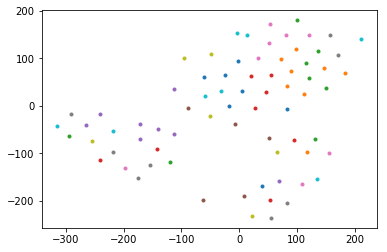

In [53]:
for label in set(val_labels):
    idxs = [i for i,el in enumerate(val_labels) if el == label]
    plt.plot(S_table_batch_tsne[idxs, 0], S_table_batch_tsne[idxs, 1], '.')
